## Email Spam Detection

#### Author - Praneesh Sharma

### Importing Libraries

In [32]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

### Importing the dataset

In [2]:
data = pd.read_csv("spam.csv", encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


As seen the in the dataset above, the last 3 columns have a very less amount of data compared to entire dataset.

Thus, they can be considered unnecessary, hence let's drop them.

### Data Preprocessing and EDA

In [4]:
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.columns = ['Category', 'Message']
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [7]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [8]:
data_spam = data[data['Category']=='spam']
data_spam.shape

(747, 2)

In [9]:
data_ham = data[data['Category']=='ham']
data_ham.shape

(4825, 2)

In [10]:
#downsampling the spam dataset
data_downsampled = data_ham.sample(data_spam.shape[0])
data_downsampled.shape

(747, 2)

In [11]:
df = pd.concat([data_spam, data_downsampled])
df.shape

(1494, 2)

In [12]:
df['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

now we have a datset with equal distribution of hap and spam messages

In [13]:
#making a flag column with numerical data for ham or spam
df['flag'] = df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.sample(5)

,Category,Message,flag
2211,ham,Just gettin a bit arty with my collages at the...,0
2306,ham,"Aight that'll work, thanks",0
909,spam,"January Male Sale! Hot Gay chat now cheaper, c...",1
1516,ham,I need to come home and give you some good lov...,0
5462,spam,Txt: CALL to No: 86888 & claim your reward of ...,1


### Model creation

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df['Message'], df['flag'], stratify=df['flag'])

In [18]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
# def get_sentence_embeding(sentences):
#     preprocessed_text = bert_preprocess(sentences)
#     return bert_encoder(preprocessed_text)['pooled_output']

In [19]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [25]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [26]:
model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 215s 6s/step - loss: 0.6839 - accuracy: 0.5580 - precision: 0.5614 - recall: 0.5304
Epoch 2/10
35/35 [==============================] - 198s 6s/step - loss: 0.5374 - accuracy: 0.7866 - precision: 0.7744 - recall: 0.8089
Epoch 3/10
35/35 [==============================] - 654s 19s/step - loss: 0.4579 - accuracy: 0.8527 - precision: 0.8496 - recall: 0.8571
Epoch 4/10
35/35 [==============================] - 187s 5s/step - loss: 0.4046 - accuracy: 0.8598 - precision: 0.8387 - recall: 0.8911
Epoch 5/10
35/35 [==============================] - 195s 6s/step - loss: 0.3737 - accuracy: 0.8687 - precision: 0.8542 - recall: 0.8893
Epoch 6/10
35/35 [==============================] - 307s 9s/step - loss: 0.3466 - accuracy: 0.8813 - precision: 0.8739 - recall: 0.8911
Epoch 7/10
35/35 [==============================] - 329s 10s/step - loss: 0.3221 - accuracy: 0.8911 - precision: 0.8856 - recall: 0.8982
Epoch 8/10
35/35 [============================

### Using the model

In [34]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 67s 5s/step


In [38]:
Y_predicted = np.where(y_predicted > 0.5, 1, 0)

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(Y_test, y_predicted)
cm 

array([[167,  20],
       [  9, 178]], dtype=int64)

Text(33.0, 0.5, 'Actual')

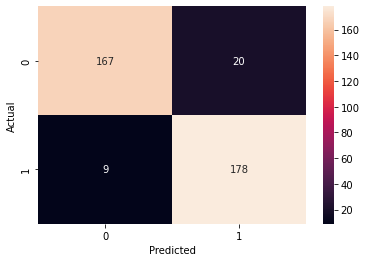

In [41]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [27]:
model.evaluate(X_test, Y_test)

12/12 [==============================] - 69s 6s/step - loss: 0.2791 - accuracy: 0.9225 - precision: 0.8990 - recall: 0.9519


[0.279112309217453, 0.9224599003791809, 0.8989899158477783, 0.9518716335296631]

In [31]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.81848705],
       [0.85208297],
       [0.8442689 ],
       [0.25834754],
       [0.14094095]], dtype=float32)